<span style="font-size: 14pt">MIPT, Advanced ML, Autumn 2017</span>

<span style="font-size: 16pt"> HW#1 </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Organization Info</h1> 

**Дополнительный материал для выполнения дз**:
- Лукишн Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.
- Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall <номер_группы> <фамилия>``, к примеру -- ``ML2017_Aut_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall Question <Содержание вопроса>``

--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было 

<h1 align="center">Check Questions (15%)</h1> 

Ответе на вопросы своими словами (загугленный материал надо пересказать), ответ обоснуйте (напишите и ОБЪЯСНИТЕ формулки если потребуется), если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1**: Опишите, как изменяется адаптивная способность алгоритма ЭСС при изменении параметра $\alpha$ от 0 до 1.

<Ответ>

**Вопрос 2**: Каким следует выбрать параметр сглаживания тренда $\alpha_2$ в модели Хольта (линейный тренд) в случае, когда вы предсказываете временной ряд 1) с плавно меняющимя трендом; 2) стохастически меняющися трендом?

<Ответ>

**Вопрос 3**: Докажите  эквивалетность формул расчёта (в рекуррентной форме и в форме корректировки прогноза (correction error form) )скрытых компонент временного ряда в модели Тейла-Вейджа (период сезонность обозначается $p$):
$$l_t = \alpha (y_t - s_{t-p}) + (1-\alpha) (l_{t-1} + b_{t-1} ) \color{red}{=} l_{t-1} + b_{t-1} + \alpha e_t;$$,
    $$ b_t = \beta (l_{t} - l_{t-1} ) + (1-\beta) b_{t-1} \color{red}{=} b_{t-1} + \alpha\beta e_t;$$,
    $$ s_t = \gamma (y_t-l_t) + (1-\gamma) s_{t-p} \color{red}{=} s_{t-p} + \gamma(1-\alpha)e_t.$$,

<Ответ>

**Вопрос 4**: Выведите формулу расчёта скрытых компонент в форме корректировки прогноза (correction error form) временного ряда в модели ЭС с линейным затухающим трендом (WS with additive damped trend):

$$\hat{y}_{t+d|t} = l_t + \left(\phi + \phi^2 + \dots + \phi^{d}\right) b_t.$$,
   
Скрытые компоненты ВР согласно модели в рекуррентной форме записываются:
    $$ l_{t}       = \alpha y_t + \left(1-\alpha\right) \left(l_{t-1} +\phi b_{t-1}\right),$$,
    $$ b_t         = \beta \left(l_t - l_{t-1}\right) + \left(1-\beta\right)\phi b_{t-1}.$$


<Ответ>

-----------
PS: Если проверяющий не понял ответ на большинство вопросов, то будет пичалька. Пишите так, чтобы можно было разобраться. 

<h1 align="center"> Practice</h1>
#  1. reading data (5%)

  * Download data for following data sets
     - 1) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv </span>(1 TS of monthly wage in Russia)

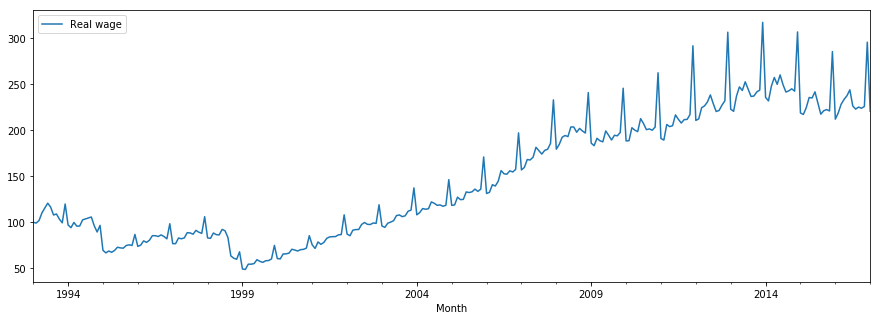

In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils import InitExponentialSmoothing, BuildForecast, plotTSForecast
from utils import qualityRMSE, qualityMedianAE, qualityMACAPE, qualitySSE, qualityMSE, qualityMAPE 

%matplotlib inline

wage = pd.read_csv('monthly-wage.csv', sep=';', decimal=".", index_col='Month', parse_dates=True, dayfirst=True)
wage.plot(figsize=(15,5))

# 2. Build the Forecast with  IES (5%)

You need to apply IES model (see seminar 1) for the TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.


* 0) Forecast Wage TS with SES $\alpha=.1$.
* 1) Find the best param $\alpha$ of SES for data period from 09.1998 to 01.2015. Is the optimal value close to 0 or 1? (You 
can choose any loss function above).
* 2) Draw the forecast that correspond to IES with optimial value $\alpha$ (use time steps from 09.1998 to 01.2017.)
     Conclude whether IES can be used for this TS? If can not than explain why.
* 3) Calculate loss of the forecast of TS in [02.2015, 01.2017]. (You can choose any Loss function from seminar 1).

## 1) Search for the optimal $\alpha$ 

In [2]:
def SimpleExponentialSmoothing(x, h, alpha):
    T = len(x)
    forecast = [np.NaN]*(T+h)
    y = x[0]
    for i in range(T):
        if not math.isnan(x[i]):
            if math.isnan(y):
                y=x[i]
            y = y*(1-alpha) + alpha*x[i]
        forecast[i+h] = y
    return forecast

Best alpha = 0.387755102041
Score = 0.941517267586


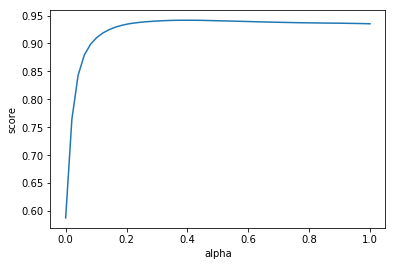

In [3]:
# find optimal alpha
h = 1
start = wage.index[-1] + timedelta(1)
end = wage.index[-1] + timedelta(h)
pretenders = np.linspace(0, 1, 50)
scores = []
best_alpha = 0
best_score = 0
for alpha in pretenders:
    range_ = pd.date_range(start, end)
    forecast = pd.DataFrame(index = wage.index.append(range_), columns = wage.columns)
    forecast['Real wage'] = SimpleExponentialSmoothing(wage['Real wage'], h, alpha)
    quality = 1.0 - qualityMAPE(wage['Real wage'].loc['1998-09-01':'2015-01-01'],forecast['Real wage'].loc['1998-09-01':'2017-01-01'])[0]
    scores.append(quality)
    if quality > best_score:
        best_score = quality
        best_alpha = alpha
    
# show results
print("Best alpha = " + str(best_alpha))
print("Score = " + str(best_score))
plt.plot(pretenders, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.show()

In [6]:
def find_optimum(data, make_forecast, pretenders = np.linspace(0, 1, 50)):
    h = 1
    start = wage.index[-1] + timedelta(1)
    end = wage.index[-1] + timedelta(h)
    scores = []
    best = 0
    best_score = 0
    for pretender in pretenders:
        range_ = pd.date_range(start, end)
        forecast = pd.DataFrame(index = wage.index.append(range_), columns = wage.columns)
        forecast['Real wage'] = make_forecast(data, h, pretender)
        quality = 1.0 - qualityMAPE(wage['Real wage'].loc['1998-09-01':'2015-01-01'], forecast['Real wage'].loc['1998-09-01':'2017-01-01'])[0]
        scores.append(quality)
        if quality > best_score:
            best_score = quality
            best = pretender
            
    # show results
    print("Best = " + str(best))
    print("Score = " + str(best_score))
    plt.plot(pretenders, scores)
    plt.xlabel("parameter")
    plt.ylabel("score")
    plt.show()
    return (best, best_score)

def show_forecast(make_forecast):
    h = 1
    start = wage.index[-1] + timedelta(1)
    end = wage.index[-1] + timedelta(h)
    range_ = pd.date_range(start, end)
    forecast = pd.DataFrame(index = wage.index.append(range_), columns = wage.columns)
    data = wage['Real wage']
    forecast['Real wage'] = make_forecast(data, h)

    wage['Real wage'].loc['1998-09-01':'2015-01-01'].plot(figsize=(15,5), linewidth=1.0)
    forecast['Real wage'].loc['1998-09-01':'2017-01-01'].plot(figsize=(15,5), linewidth=1.0)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

## 2) draw the forecast with optimial value $\alpha $

Alpha:
Best = 0.387755102041
Score = 0.941517267586


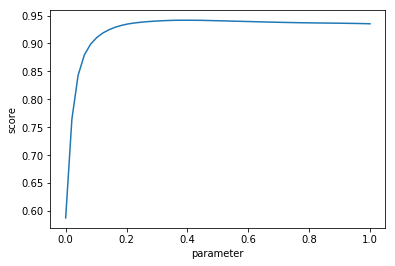

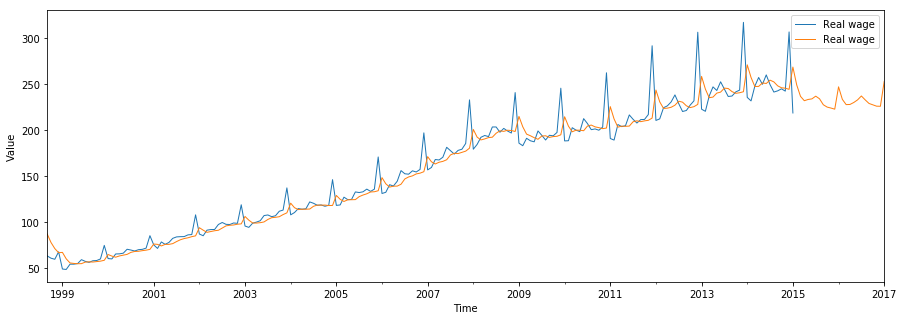

In [7]:
# find optimal parameters
print('Alpha:')
(best_alpha, best_score) = find_optimum(wage['Real wage'], lambda data, h, pretender: SimpleExponentialSmoothing(data, h, pretender))
show_forecast(lambda data, h: SimpleExponentialSmoothing(data, h, best_alpha))

## 3) Calculate loss of the forecast of TS in [02.2015, 01.2017]

In [8]:
quality = 1.0 - qualityMAPE(wage["Real wage"].loc['2015-02-01':'2017-01-01'], forecast['Real wage'].loc['2015-02-01':'2017-01-01'])[0]
print("Loss of the forecast of TS in [02.2015, 01.2017] is " + str(quality))

Loss of the forecast of TS in [02.2015, 01.2017] is 0.930924836336


# 3. Winters model for Additive Seasonality (25%)
You need to realize ES model for TS with additive seasonality and then use it for forecasting real TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.

* 1) Realize Winters model for Seasonal TS
* 2) Find optimal params $\alpha$ (smoothing of level) and $\gamma$ (smoothing of seasonality) (use data from 09.1998 to 01.2015).(Loss function should be the same as in task 2.)
* 3) Draw the forecast that correspond optimal values $\alpha$ and $\gamma$ (data from 09.1998 to 01.2017). 
* 4) Calculate accuracy of the forecast of TS in [02.2015, 01.2017] (Loss function should be the same as in task 2.). Compare it with accuracy of IES: is it better? 
* 5) Conclude whether Winter's ES can be used for this TS?

In [9]:
# Start with this code
###################### Winters Exponential Smoothing #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    delts <scalar in [0,1]> - seasonality smoothing parameter

def WintersExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    p = Params['seasonality_period']
    
    forecast = [np.NaN] * (T + h)
    l = np.NaN
    s = []
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l = x[cntr]
            if len(s)==0:
                for i in range(p):
                    s.append(x[i])
            if cntr < p:
                l = alpha * (x[cntr] - s[cntr]) + (1 - alpha) * l
            else:
                s.append(beta * (x[cntr] - l) + (1 - beta) * s[cntr - p])
                l = alpha * (x[cntr] - s[cntr - p]) + (1 - alpha) * l
            
        forecast[cntr+h] = l + s[cntr-p+1]
    return forecast

Alpha
Best = 0.69387755102
Score = 0.975332480645


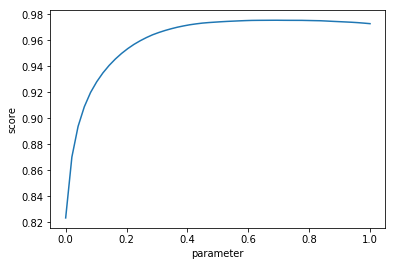

Beta
Best = 0.469387755102
Score = 0.975364115151


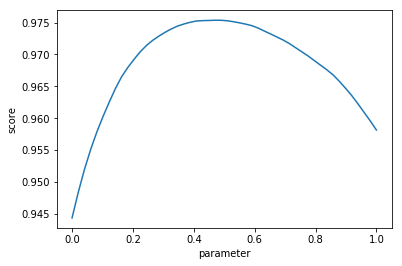

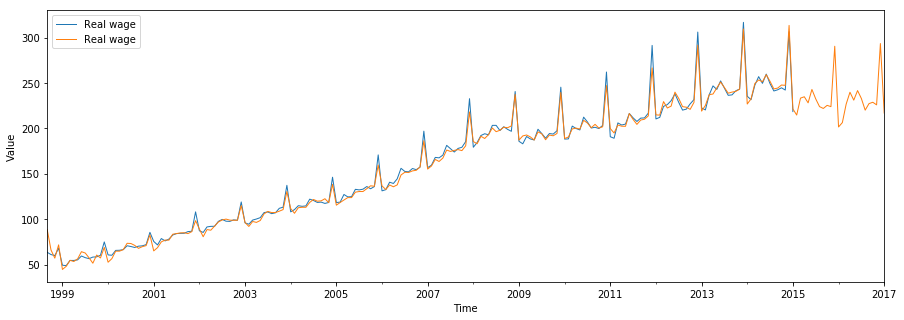

In [10]:
# find optimal alpha
print('Alpha')
(best_alpha, best_score) = find_optimum(wage['Real wage'], lambda data, h, pretender: WintersExponentialSmoothing(wage['Real wage'], h, {'alpha':pretender, 'beta':0.5, 'seasonality_period':12}))
print('Beta')
(best_beta, best_score) = find_optimum(wage['Real wage'], lambda data, h, pretender: WintersExponentialSmoothing(wage['Real wage'], h, {'alpha':best_alpha, 'beta':pretender, 'seasonality_period':12}))

show_forecast(lambda data, h: WintersExponentialSmoothing(data, h, {'alpha': best_alpha, 'beta': best_beta, 'seasonality_period':12}))

# 4. Theil-Wage model for TS with linear trend and seasonality (25%)
You need to realize Theil-Wage model and then use it for forecasting real TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.

* 1) Realize Theil-Wage model for
* 2) Find optimal params $\alpha$ (smoothing of level), $\beta$ (smoothing trend) and $\gamma$ (smoothing of seasonality) (use data from 09.1998 to 01.2015).(Loss function should be the same as in task 2.)
* 3) Draw forecast with optimal values $\alpha$, $\beta$ and $\gamma$ from 09.1998 to 01.2017. 
* 4) Calculate accuracy of the forecast of TS in [02.2015, 01.2017] (Loss function should be the same as in task 2.). Compare it with accuracy of Winters model: is it better than the last one? 
* \*5) Suggest how can the Theil-Wage model be improved to make accuracy of forecast better?

In [11]:
def TheilWintersExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    forecast = [np.NaN] * (T + h)
    
    l = np.NaN
    b = np.NaN
    s = []
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l = x[cntr]
            if math.isnan(b):
                b = 0
            
            if len(s) == 0:
                for i in range(p):
                    s.append(x[i])

            prev = l
            if cntr < p:
                l = alpha * (x[cntr] - s[cntr]) + (1 - alpha) * (l + b)
            else:
                s.append(gamma * (x[cntr] - l) + (1 - gamma) * s[cntr - p])
                l = alpha * (x[cntr] - s[cntr - p]) + (1 - alpha) * (l + b) 
                
            b = beta * (l - prev) + (1 - beta) * b
            
        forecast[cntr + h] = l + b + s[cntr - p + 1]
    return forecast

Alpha
Best = 0.69387755102
Score = 0.975332480645


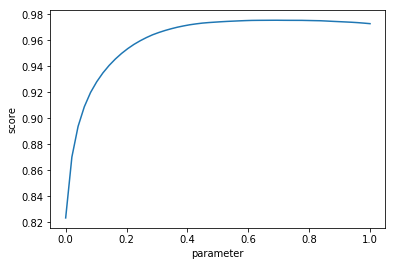

Beta
Best = 0.0
Score = 0.975332480645


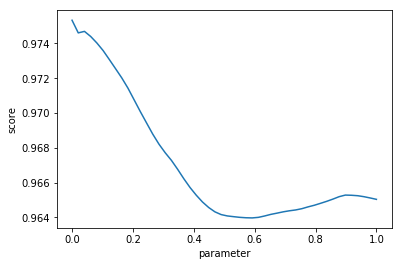

Gamma
Best = 0.469387755102
Score = 0.975364115151


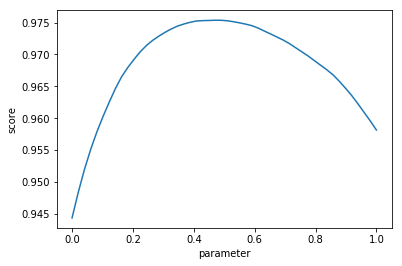

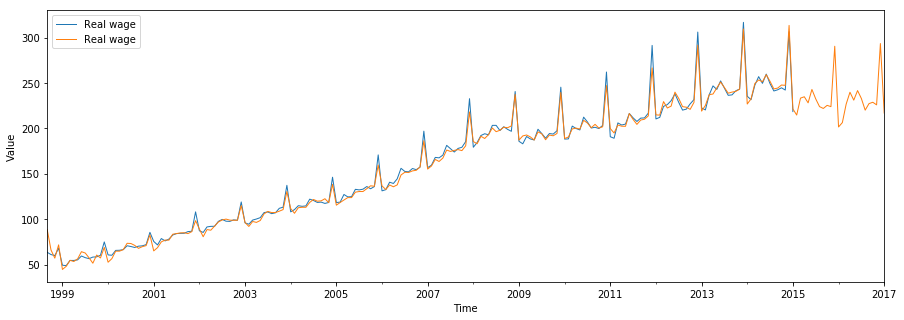

In [13]:
print('Alpha')
(best_alpha, score) = find_optimum(wage['Real wage'], lambda data, h, pretender: TheilWintersExponentialSmoothing(wage['Real wage'], h, {'alpha': pretender, 'beta': 0, 'gamma': 0.5, 'seasonality_period':12}))

print('Beta')
(best_beta, score) = find_optimum(wage['Real wage'], lambda data, h, pretender: TheilWintersExponentialSmoothing(wage['Real wage'], h, {'alpha': best_alpha, 'beta': pretender, 'gamma': 0.5, 'seasonality_period':12}))

print('Gamma')
(best_gamma, score) = find_optimum(wage['Real wage'], lambda data, h, pretender: TheilWintersExponentialSmoothing(wage['Real wage'], h, {'alpha': best_alpha, 'beta': best_beta, 'gamma': pretender, 'seasonality_period':12}))

show_forecast(lambda data, h: TheilWintersExponentialSmoothing(wage['Real wage'], h, {'alpha': best_alpha, 'beta': best_beta, 'gamma': best_gamma, 'seasonality_period':12}))

# 5. Non-additive model of ES (25%)
You need to realize some ES-model that include non-addive component (or multiplicative trend or multiplicative component) and then use it for forecasting real TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.

* 1) Realize one of following ES models: ESM(A,M) (t.e. Holt-Winters model), ESM(Ad,M), ESM(M,A), ESM(M,M) model.
* 2) Find optimal params of the model (use data from 09.1998 to 01.2015). Note: if you choose damped trend model that $\phi$ you can just set it by expert opinion (say $0.98$). (Loss function should be the same as in task 2.)
* 3) Draw forecast with optimal values of it's params (data from 09.1998 to 01.2017). 
* 4) Calculate accuracy of the forecast of TS in [02.2015, 01.2017] (Loss function should be the same as in task 2.). Compare it with accuracy of Winters model and Theil-Wage model: is it better than the last one? 
* 5) Is it true that multiplicative model are more unstable than additive? Unstable means thet forecast is can diveret

In [14]:
def Smoothing5(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    forecast = [np.NaN] * (T + h)
    
    l = np.NaN
    b =np.NaN
    s = []
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l = x[cntr]
            if math.isnan(b):
                b = 0
            
            if len(s) == 0:
                s.append(1)
                for i in range(1,p):
                    s.append(x[i] / x[i-1])
                    
                    
            prev = l
            if cntr < p:
                l = alpha * (x[cntr] / s[cntr]) + (1 - alpha) * (l + b)
            else:
                s.append(gamma * (x[cntr] / l) + (1 - gamma) * s[cntr - p])
                l = alpha * (x[cntr] - s[cntr - p]) + (1 - alpha) * (l + b)
            b = beta * (l - prev) + (1 - beta) * b
            
        forecast[cntr + h] = (l + b) * s[cntr - p + 1]
    return forecast

Alpha
Best = 1.0
Score = 0.980739440293


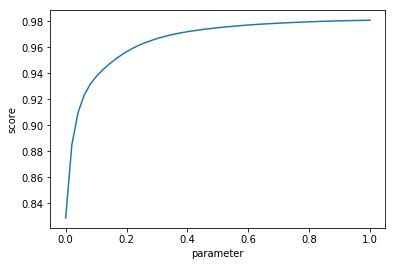

Beta
Best = 0.0
Score = 0.980739440293


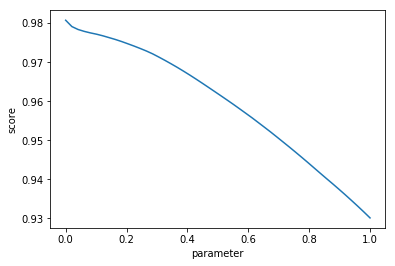

Gamma
Best = 0.469387755102
Score = 0.980746540719


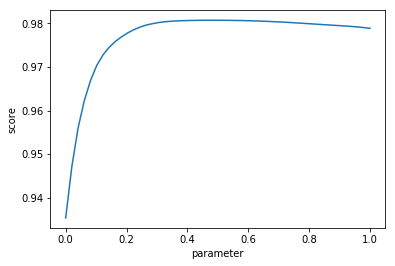

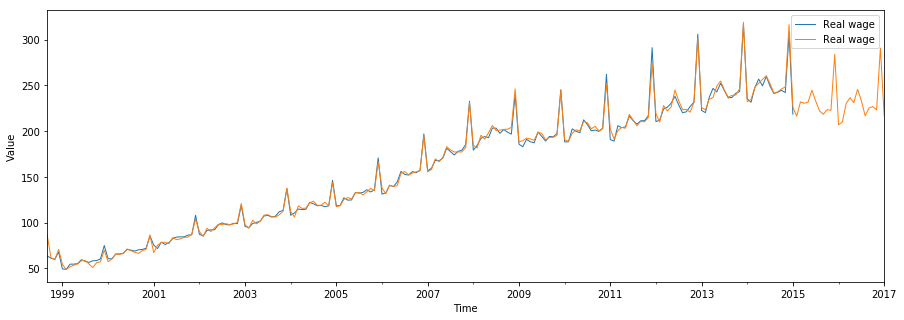

In [15]:
print('Alpha')
(best_alpha, score) = find_optimum(wage['Real wage'], lambda data, h, pretender: Smoothing5(wage['Real wage'], h, {'alpha': pretender, 'beta': 0, 'gamma': 0.5, 'seasonality_period':12}))

print('Beta')
(best_beta, score) = find_optimum(wage['Real wage'], lambda data, h, pretender: Smoothing5(wage['Real wage'], h, {'alpha': best_alpha, 'beta': pretender, 'gamma': 0.5, 'seasonality_period':12}))

print('Gamma')
(best_gamma, score) = find_optimum(wage['Real wage'], lambda data, h, pretender: Smoothing5(wage['Real wage'], h, {'alpha': best_alpha, 'beta': best_beta, 'gamma': pretender, 'seasonality_period':12}))

show_forecast(lambda data, h: Smoothing5(wage['Real wage'], h, {'alpha': best_alpha, 'beta': best_beta, 'gamma': best_gamma, 'seasonality_period':12}))

FIN